In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

# print("Path to dataset files:", path)

In [3]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [4]:
ANNOTATION_PATH = 'face-mask-detection/versions/1/annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH) if filename.endswith('.xml')]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()


label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

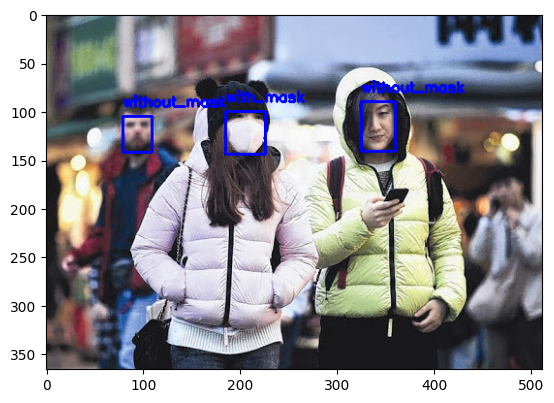

In [5]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('face-mask-detection/versions/1/images/maksssksksss0.png', parse_xml('face-mask-detection/versions/1/annotations/maksssksksss0.xml'))

In [6]:
augmentation = ImageDataGenerator(
    zoom_range = 0.1,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    rotation_range = 25,
    fill_mode = 'nearest'
)


In [7]:
#get images and labels from the pipeline.pkl file
import pickle
with open('pipeline.pkl', 'rb') as f:
    pipeline_data = pickle.load(f)

face_images = pipeline_data['face_images']
face_labels = pipeline_data['face_labels']



In [8]:
train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, shuffle=True, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, shuffle=True, stratify=test_val_y)

train_y_cat = tf.keras.utils.to_categorical(train_y)
val_y_cat = tf.keras.utils.to_categorical(val_y)
test_y_cat = tf.keras.utils.to_categorical(test_y)

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y_cat.shape, val_y_cat.shape, test_y_cat.shape)


(2850, 224, 224, 3) (611, 224, 224, 3) (611, 224, 224, 3)
(2850, 3) (611, 3) (611, 3)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Clear any previous models/sessions

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\User\miniconda3\envs\env3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 518ms/step - accuracy: 0.8437 - loss: 0.6635 - val_accuracy: 0.9296 - val_loss: 0.2324
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 482ms/step - accuracy: 0.9288 - loss: 0.2460 - val_accuracy: 0.9280 - val_loss: 0.2559
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 482ms/step - accuracy: 0.9372 - loss: 0.1905 - val_accuracy: 0.9378 - val_loss: 0.1993
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 480ms/step - accuracy: 0.9508 - loss: 0.1593 - val_accuracy: 0.9493 - val_loss: 0.1716
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 473ms/step - accuracy: 0.9448 - loss: 0.1504 - val_accuracy: 0.9394 - val_loss: 0.1940
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 477ms/step - accuracy: 0.9578 - loss: 0.1372 - val_accuracy: 0.9444 - val_loss: 0.1865
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.9581 - loss: 0.1147 - val_accuracy: 0.9542 - val_loss: 0.1718
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.9717 - loss: 0.0794 - val_accu

Text(0, 0.5, 'Accuracy')

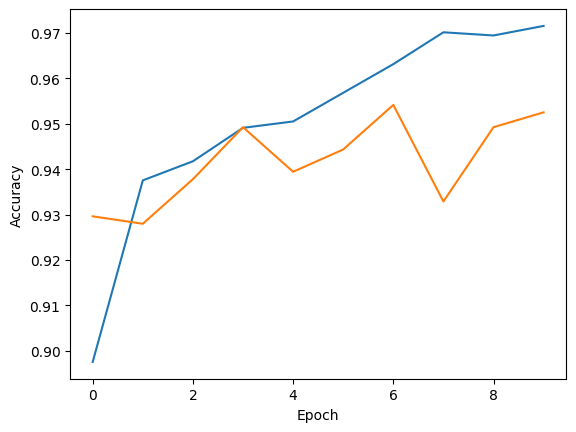

In [10]:
model.fit(train_x, train_y_cat, epochs=10, batch_size=32, validation_data=(val_x, val_y_cat))
history = model.history.history

# Plot training and validation accuracy
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step


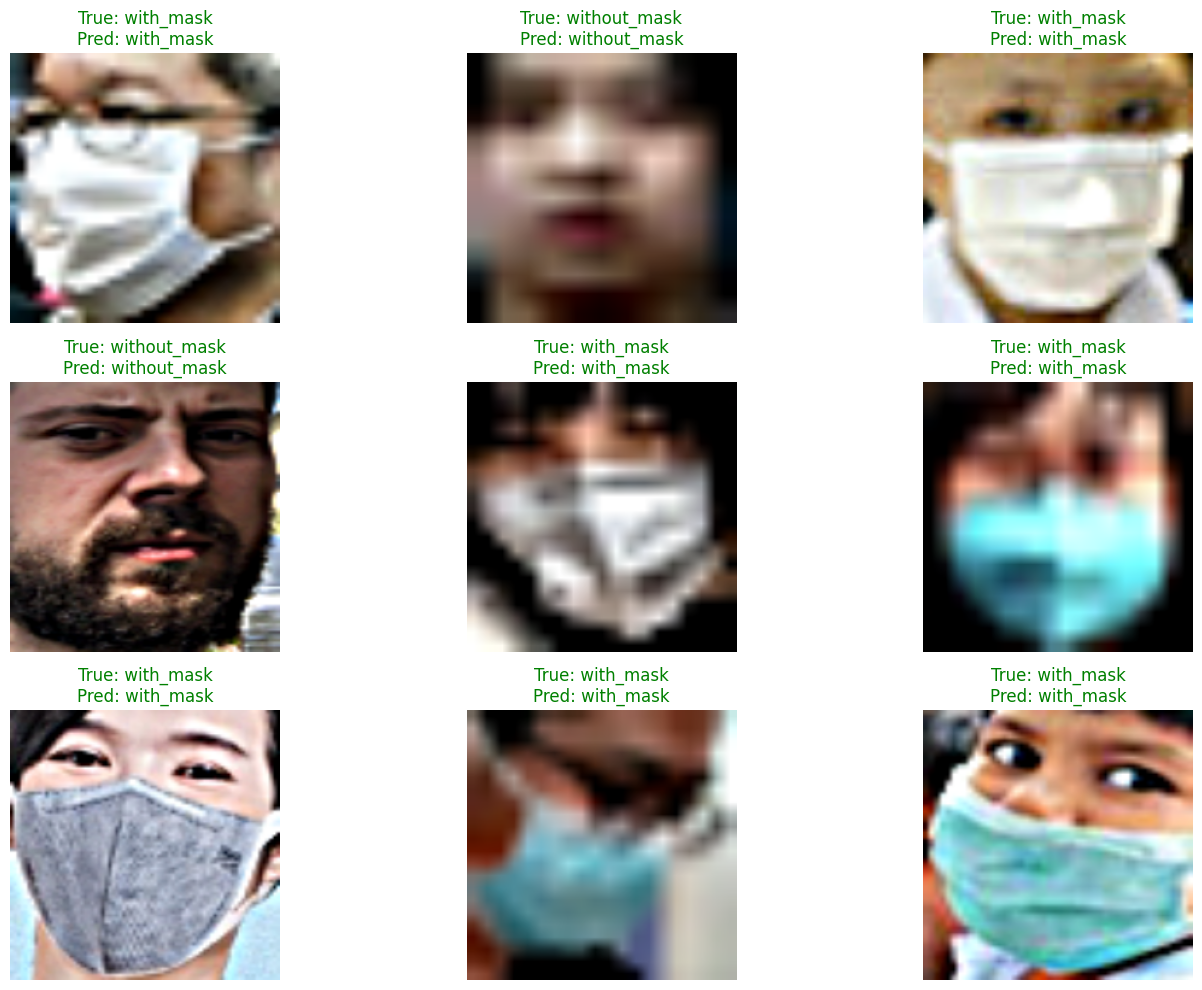

In [11]:
# Get predictions for test data
predictions = model.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_y

# Create a mapping from numeric labels back to string labels
label_mapping = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}

# Plot a grid of images with their predictions
plt.figure(figsize=(15, 10))
for i in range(9):  # Show first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.cvtColor(((test_x[i] + 1) * 127.5).astype(np.uint8), cv2.COLOR_BGR2RGB))
    
    true_label = label_mapping[true_labels[i]]
    pred_label = label_mapping[predicted_labels[i]]
    color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
    
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
%pip install scikeras

Note: you may need to restart the kernel to use updated packages.
